# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import *
from qiskit.providers.ibmq.managed import IBMQJobManager
from qiskit.tools.monitor import job_monitor
from qiskit.ignis.mitigation.measurement import (complete_meas_cal,CompleteMeasFitter)

In [2]:
token = '' # Put in your IBM token
IBMQ.save_account(token, overwrite=True)
IBMQ.load_account()
provider = IBMQ.get_provider(group='open')

In [26]:
backend_sims = ["ibmq_qasm_simulator", "simulator_statevector"]
backends = ["ibmq_manila", "ibmq_quito", "ibmq_belem", "ibmq_lima", "ibm_oslo", "ibm_nairobi"]

job_manager = IBMQJobManager()
backend = provider.get_backend(backends[4]) # Either use backend_sim for simulator, or backends[x] for device
print(backend)

ibm_oslo


In [4]:
# Functions for states/gates requried for the SOP=COP circuits
def get_modified_state(beta, outcome, a, b):
    """
    Returns |phi_outcome> =  T^dagger |psi(+/- beta)_outcome> 
            where  |psi(+/- beta)_outcome> is the + or - eigenstate of the O(beta) operator.
    Inputs: beta - Rotation angle
            outcome - 0 for the + outcome, 1 for the - outcome
            a, b - Coefficients of the T operator (aI + bX)
    Outputs: Returns |phi_outcome> as 1d numpy array. NOTE: NOT NORMALIZED
    """
    if outcome == 0:
        state = np.array([np.exp(complex(0,beta)), 1])/np.sqrt(2)  # + Eigenstate of O(beta)
    else:  # Outcome == 1
        state = np.array([-np.exp(complex(0,beta)), 1])/np.sqrt(2) # - Eigenstate of O(beta)
    flipped_state = np.array([state[1], state[0]])
    return np.conjugate(a) * state + np.conjugate(b) * flipped_state


def get_orthogonal_vector(vector):
    """
    Returns 2d vector orthogonal to the given vector
    Inputs: vector - a 2-entry 1d numpy array
    Outputs: vector_perp - a 2-entry 1d numpy array, orthogonal to the input vector
    """
    vector_perp = np.array([-np.conjugate(vector[1]), np.conjugate(vector[0])])
    # For a complex vector [v1, v2], an orthogonal vector is given by [-v2^*, v1^*].
    return vector_perp
    

def shift_meas_basis(qc, beta, qubit, outcome, a, b):
    """
    Shifts measurement basis for the specified qubit by applying unitary on that qubit for measurements in nontrivial basis.
    Original unitary is R_z(+/- beta) H (corresponding to measurement in O(+/- beta) = cos(beta) X +/- sin(beta)Y). 
    New unitary is U = |0><phi_outcome| + |1><phi_outcome^perp| where |phi_outcome> = T^dagger |psi(+/- beta)_outcome>
        where |psi(+/- beta)_outcome> is the + or - eigenstate of the O(+/- beta) operator.
    Inputs: qc - QuantumCircuit object
            beta - Rotation angle
            qubit - Which qubit we are shifting the measurement basis for (by applying the unitary). Must be 0 or 2.
            outcome - 0 for measuring in the + outcome basis, 1 for the - outcome basis
            a, b - Coefficients of the T operator (aI + bX)
    Outputs: None
    """
    zero_state = np.array([1, 0])
    one_state = np.array([0, 1])
    phi = get_modified_state(beta, outcome, a, b)
    phi_perp = get_orthogonal_vector(phi)
    U = np.outer(zero_state, phi.conj())/np.sqrt(phi.conj() @ phi) + np.outer(one_state, phi_perp.conj())/np.sqrt(phi_perp.conj() @ phi_perp)  #  U = |0><phi|/sqrt(<phi|phi>) + |1><phi^perp|/sqrt(<phi^perp|phi^perp>)
    if beta == 0:
        sign = ""
    else:
        sign = beta/abs(beta)
    gate_label = "U(" + str(sign) + str(np.round(beta, 3)) + str(outcome)
    qc.unitary(U, qubit, label = gate_label)

In [5]:
# Functions for preparing + running COP circuits

def generate_circuit(beta, a, b, qubit_3_outcome, meas_last_y):
    """
    Generates one circuit corresponding to one measurement outcome of experiment we are trying to simulate.
    A cluster state is prepared, then a rotation is conducted on the third site. A state tomography measurement
    (either X or Y) is conducted on the last qubit. Post processing is done of outcomes to account for non-unitary T.
    Inputs: beta - Rotation angle
            a, b - Coefficients for the T tensor, which is a product of aI + bX.
            qubit_3_outcome - Whether the position 3 qubit was measured to be the + or - outcome
            meas_last_y - Whether the fifth qubit is measured in the Y or X basis
    Outputs: The circuit
    """
    # Initializes circuit
    qr = QuantumRegister(5)
    qc = QuantumCircuit(qr)
    
    # Creates 4-qubit chain
    qc.h(qr)
    
    qc.cz([0, 1, 2, 3], [1, 2, 3, 4])

    qc.barrier(qr)
    
    # Measure qubits 1, 2, 4 in x basis
    qc.h(0)
    qc.h(1)
    qc.h(3)

    # Measure qubit 3 in rotated basis
    shift_meas_basis(qc, beta, 2, qubit_3_outcome, a, b)
    
    # Measure last qubit in Y basis (or X basis)
    if meas_last_y == 0:
        qc.sdg(4)  
    qc.h(4)

    qc.measure_all()
    
    return qc

def generate_circuit_list(beta, a, b):
    """
    Generates 2 circuits to simulate the 2 experiments 
    (one circuit corresponding to each measurement outcome of experiment we are trying to simulate)
    Inputs: beta - Rotation angle
            a, b - Coefficients for the T tensor, which is a product of aI + bX.
    Outputs: List of 4 circuits.
    """ 
    qc_list = []
    for meas_last_y in range(2):
        for qubit_3_outcome in range(2):
            qc_list.append(generate_circuit(beta, a, b, qubit_3_outcome, meas_last_y))
    return qc_list

def run_circuit(qc_list, backend, best_qubits, shots_num, job_manager, meas_filter = 0):
    """
    Runs quantum circuit(s)
    Inputs: qc_list - List of QuantumCircuit Objects
           backend - Which backend (simulator or device) to use
           best_qubits - which qubits to use on the backend
           shots_num - how many shots per experiment'
           job_manager - IBMQ job manager
           meas_filter - Measurement error mitigation filter; by default is not applied.
    Outputs: List containing 4 dictionaries corresponding to counts/experimental results from supplied experiments.
    """
    qc_trans = transpile(qc_list, backend=backend, initial_layout=best_qubits)
    job_exp = job_manager.run(qc_trans, backend=backend, shots=shots_num, name='SPTexp_SOPCOP')
    for i in range(len(job_exp.jobs())):
        job_monitor(job_exp.jobs()[i])
    print('All jobs have finished.')
    results = job_exp.results()
    
    if meas_filter != 0:
        counts_mit_list = []
        for i in range(4):
            r = results.get_counts(i)
            mit_r = meas_filter.apply(r)
            counts_mit_list.append(mit_r)
        return counts_mit_list   
    else:
        counts_list = []
        for i in range(4):
            counts_list.append(results.get_counts(i))
        return counts_list

In [6]:
# Functions for post-processing data
def get_norms(beta, a, b):
    """
    Calculate (squared) norms of the two |phi_outcome> =  T^dagger |psi(+/- beta)_outcome> states
    Inputs: beta - Rotation angle
            a, b - Coefficients for the T tensor, which is a product of aI + bX.
    Outputs: List containing two squared norms (0/1 outcome norms for third qubit (with +beta)
    """
    phi_qubit0_plus = get_modified_state(beta, 0, a, b)
    norm_0_plus = phi_qubit0_plus.conj() @ phi_qubit0_plus
    phi_qubit0_minus = get_modified_state(beta, 1, a, b)
    norm_0_minus = phi_qubit0_minus.conj() @ phi_qubit0_minus

    norms = [norm_0_plus, norm_0_minus]
    return norms

def get_probability(counts, qubit_3_outcome, meas_last_y, a, b):
    """
    Note that qiskit reads from right to left; i.e. the rightmost is the 0 qubit, the leftmost is 3.
    
    Inputs: counts - Dictionary containing measurement statistics
    Outputs: Probability for the 0-qubit = 0 and 2-qubit = 0 (+) outcome.
    """
    states = counts.keys()
    total_counts = 0
    pos_counts = 0
    neg_counts = 0
    for state in states:
        if state[2] == "0":
            total_counts += counts.get(state)
            s1 = int(state[4])
            s3 = qubit_3_outcome
            s5 = int(state[0])
            if meas_last_y == 0:
                s4 = int(state[1])
            else:
                s4 = 0
            outcome = (s1 + s3 + s4 + s5) % 2
            if outcome == 0:
                pos_counts += counts.get(state)
            else:
                neg_counts += counts.get(state)
    pos_prob = pos_counts/total_counts
    neg_prob = neg_counts/total_counts
    return [pos_prob, neg_prob]
        

def get_probabilities(counts_list, a, b):
    """
    Converts counts from the 4 circuits (2 circuits each for measuring <X>, <Y>) into probabilities.
    """
    avgY_probs = np.array([get_probability(counts_list[0], 0, 0, a, b), get_probability(counts_list[1], 1, 0, a, b)])
    avgX_probs = np.array([get_probability(counts_list[2], 0, 1, a, b), get_probability(counts_list[3], 1, 1, a, b)])
    return avgY_probs, avgX_probs


def post_process_results(counts_list, beta, a, b):
    """
    Inputs: counts_list - measurement outcomes from 4 circuits
    beta - rotation angle
    a, b - Parameters for T.

    Outputs:Yavg, Xavg
    """
    avgY_probs, avgX_probs = get_probabilities(counts_list, a, b)
    norms = get_norms(beta, a, b)

    for i in range(2):
        avgY_probs[i] = avgY_probs[i] * norms[i]
        avgX_probs[i] = avgX_probs[i] * norms[i]

    total_Y = np.sum(avgY_probs)
    total_X = np.sum(avgX_probs)

    for i in range(2):
        avgY_probs[i] = avgY_probs[i]/total_Y
        avgX_probs[i] = avgX_probs[i]/total_X
    
    Yavg = avgY_probs[0][0] + avgY_probs[1][0] - avgY_probs[0][1] - avgY_probs[1][1]
    Xavg = avgX_probs[0][0] + avgX_probs[1][0] - avgX_probs[0][1] - avgX_probs[1][1]

    return Yavg, Xavg


In [7]:
# Measurement error calibrations
def run_meas_error_calibs(backend, best_qubits, shots_num):
    """
    Runs measurement error calibration circuits and returns a measurement error mitigation filter
    Inputs: backend - Which backend (simulator or device) to use
           best_qubits - which qubits to use on the backend
           shots_num - how many shots per experiment
    Outputs: meas_filter - Measurement error mitigation filter based on calibrations
    """
    qc_err = qiskit.QuantumRegister(len(best_qubits))
    meas_calibs, state_labels = complete_meas_cal(qr=qc_err, circlabel='mcal')
    meas_calibs = transpile(meas_calibs, backend=backend, initial_layout=best_qubits)
    job_err = qiskit.execute(meas_calibs, backend=backend, shots=shots_num)
    job_monitor(job_err)
    cal_result = job_err.result()
    meas_fitter = CompleteMeasFitter(cal_result, state_labels, circlabel='mcal')
    meas_filter = meas_fitter.filter
    return meas_filter


In [8]:
def one_exp_point(backend, best_qubits, shots_num, job_manager, beta, a, b, meas_filter = 0):
    """
    Obtains COP (<Y>, <X>) data for one rotation angle beta. 
    """
    qc_list = generate_circuit_list(beta, a, b)
    counts_list = run_circuit(qc_list, backend, best_qubits, shots_num, job_manager, meas_filter)
    Yavg, Xavg = post_process_results(counts_list, beta, a, b)
    return Yavg, Xavg

def many_exp_point(backend, best_qubits, shots_num, job_manager, beta_ar, a, b, meas_filter=0):
    """
    Obtains COP (<Y>, <X>) data for multiple rotation angles beta.
    """
    Yavg_ar = []
    Xavg_ar = []

    for beta in beta_ar:
        Yavg, Xavg = one_exp_point(backend, best_qubits, shots_num, job_manager, beta, a, b, meas_filter)
        Yavg_ar.append(Yavg)
        Xavg_ar.append(Xavg)
    return np.array(Yavg_ar), np.array(Xavg_ar)

In [27]:
best_qubits = [0, 1, 2, 3, 4]
shots_num = 8000
beta_ar = [0, np.pi/50, np.pi/10, np.pi/6, np.pi/4, np.pi/3]
a = 1
b = 0 # 1, 0 for the cluster state; can be replaced with coefficients from VQE for arbitrary SPT states.

In [30]:
meas_filter = run_meas_error_calibs(backend, best_qubits, shots_num)

Job Status: job is queued (19)    

KeyboardInterrupt: 

In [ ]:
Yavg_ar, Xavg_ar = many_exp_point(backend, best_qubits, shots_num, job_manager, beta_ar, a, b, meas_filter)

Job Status: job is queued (75)    

IBMQJobApiError: '"HTTPSConnectionPool(host=\'api.quantum-computing.ibm.com\', port=443): Max retries exceeded with url: /api/Network/ibm-q/Groups/open/Projects/main/Jobs/63cc8217fbd2a7521f8c044c/status/v/1 (Caused by NewConnectionError(\'<urllib3.connection.HTTPSConnection object at 0x7f91200d60d0>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known\'))"'

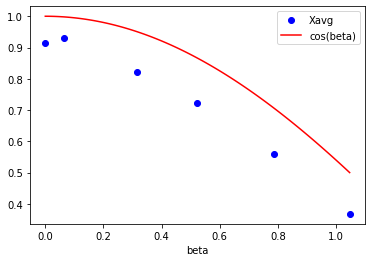

In [21]:
plt.plot(beta_ar, Xavg_ar, "bo", label = "Xavg")
plt.plot(np.linspace(0, np.pi/3, 100), np.cos(np.linspace(0, np.pi/3, 100)), "r-", label = "cos(beta)")
plt.title("Xavg vs. beta")
plt.xlabel("beta")
plt.legend()
#plt.savefig("")
plt.show()

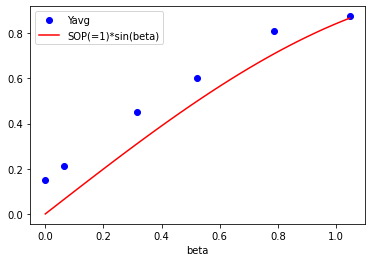

In [22]:
plt.plot(beta_ar, Yavg_ar, "bo", label = "Yavg")
plt.plot(np.linspace(0, np.pi/3, 100), 1*np.sin(np.linspace(0, np.pi/3, 100)), "r-", label = "SOP(=1)*sin(beta)")
# Modify this to be SOP * np.sin()... depending on what the SOP is
plt.title("Yavg vs. beta")
plt.xlabel("beta")
plt.legend()
#plt.savefig("")
plt.show()

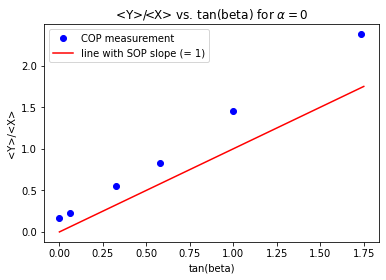

In [23]:
plt.plot(np.tan(beta_ar), Yavg_ar/Xavg_ar, "bo", label = "COP measurement")
plt.plot(np.linspace(0, 1.75, 100), 1*np.linspace(0, 1.75, 100), "r-", label = "line with SOP slope (= 1)")
# Modify slope to be SOP depending on what it is (1 for the cluster state).
plt.title(r"<Y>/<X> vs. tan(beta) for $\alpha = 0$")
plt.ylabel("<Y>/<X>")
plt.xlabel("tan(beta)")
plt.legend()
#plt.savefig("")
plt.show()